In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import multiprocessing as mp
import math
# from collections import OrderedDict
# # import datetime
# import gc
# from itertools import islice
# import datetime
# import powerlaw
# from scipy import optimize
# from scipy.special import erf, gamma
# from scipy import optimize
from IPython.display import clear_output
import warnings
from operator import itemgetter

# [Technical] Generation functions

In [155]:
def generateCGW(mean):
    g = nx.Graph()
    g.add_node(0, root = True)
    num_root_offsprings = np.random.poisson(mean)
    node_count = 1
    default_weight = 1.0
    offspring_to_generate = []
    for i in range(0,num_root_offsprings):
        g.add_node(node_count, root = False)
        g.add_edge(0, node_count, weight = default_weight)
        offspring_to_generate.append(node_count)
        node_count+=1
    while offspring_to_generate:
        if nx.number_of_nodes(g) > 10000:
            return g, False
        u = offspring_to_generate[0]
        del offspring_to_generate[0]
        num_offsprings = np.random.poisson(mean)
        for i in range(0,num_offsprings):
            g.add_node(node_count, root = False)
            g.add_edge(u, node_count, weight = default_weight)
            offspring_to_generate.append(node_count)
            node_count+=1
    return g, True

def get_tree_depth(tree):
    shortest_path_dict = nx.single_source_shortest_path_length(tree, source = 0)
    return max(shortest_path_dict.values())

def generateCGWConditionedDepth(depth):
    while True:
        g, success = generateCGW(1)
        if success and get_tree_depth(g) > depth:
            break
    return g

def addExtraEdgeCGW(g):
    h = g.copy()
    v = np.random.randint(low=1, high=nx.number_of_nodes(h)-1)
    h.add_edge(0,v)
    return h

def getPowerlawRandom(alpha):
    while True:
        x = np.random.uniform(low=0, high=1)
        t = np.power((1/(1-x)), 1/alpha)
        if t>1:
            return t

def getSpreadingCurve(g,root, alpha):
    for e in g.edges():
        g.edge[e[0]][e[1]]['weight']=getPowerlawRandom(alpha)
    dictT = nx.single_source_dijkstra_path_length(g,root, weight = 'weight')
    arrayT = sorted(dictT.values())
    return arrayT

def getAverageSpreadingCurve(M,seed,g,root,alpha):
    averageT = [0 for t in range(0,nx.number_of_nodes(g))]
    np.random.seed(seed)
    for i in range(0,M):
        #print('Running:', i, 'out of', M)
        currentT = getSpreadingCurve(g,root,alpha)
        for j in range(0,len(currentT)):
            averageT[j] += currentT[j]
    averageT = [t/M for t in averageT]
    fractionT = [k/nx.number_of_nodes(g) for k in range(1,nx.number_of_nodes(g)+1)]
    return averageT, fractionT

def getSpreadingCurveFixedWeights(g,root, alpha):
    dictT = nx.single_source_dijkstra_path_length(g, root, weight = 'weight')
    arrayT = sorted(dictT.values())
    return arrayT

def getAverageSpreadingCurveFixedWeights(M,seed, g,alpha):
    for e in g.edges():
        g.edge[e[0]][e[1]]['weight']=getPowerlawRandom(alpha)
    averageT = [0 for t in range(0,nx.number_of_nodes(g))]
    np.random.seed(seed)
    for i in range(0,M):
        #print('Running:', i, 'out of', M)
        root = np.random.choice(g.nodes())
        currentT = getSpreadingCurveFixedWeights(g,root,alpha)
        for j in range(0,len(currentT)):
            averageT[j] += currentT[j]
    averageT = [t/M for t in averageT]
    fractionT = [k/nx.number_of_nodes(g) for k in range(1,nx.number_of_nodes(g)+1)]
    return averageT, fractionT

def generateLCCErdosRenyi(n,p):
    g = nx.erdos_renyi_graph(n,p)
    graphs = list(nx.connected_component_subgraphs(g))
    h = max(graphs, key=lambda x: nx.number_of_nodes(x))
    root_marks = [False for i in range(0,nx.number_of_nodes(g))]
    default_weights = [0 for i in range(0,nx.number_of_edges(g))]
    nx.set_node_attributes(h,'root',root_marks)
    nx.set_edge_attributes(h, 'weight', default_weights)
    return h

## CGW without and with extra edge

Here we present simulations of SI spreading with power-law weights with $\alpha=0.8$. We generate a CGW tree with depth > 20, then make a copy of this tree with an edge added at random place, and for each graph we perform 20 runs of simulations with M = 400 repetitions in each simulations (each repetition = sampling of all edge weights). After we plot all obtained average spreading curves on two plots.

In [87]:
depth = 20
cgw = generateCGWConditionedDepth(depth)
cgw_e = addExtraEdgeCGW(cgw)
print('Number of nodes: ', nx.number_of_nodes(cgw))
print('Number of edges: ', nx.number_of_edges(cgw))
print('Number of edges + extra edge: ', nx.number_of_edges(cgw_e))

Number of nodes:  108
Number of edges:  107
Number of edges + extra edge:  108


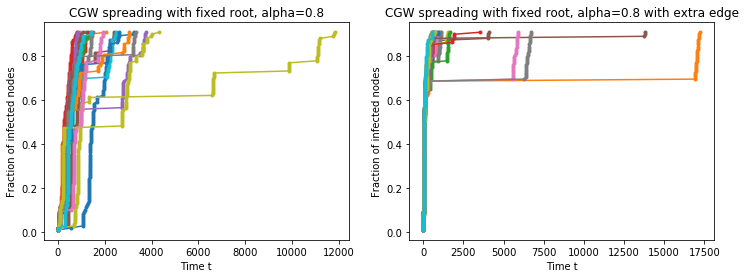

In [88]:
alpha = 0.8
M=400
num_repetitions = 20
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
pool = mp.Pool(processes=4)
seeds = [np.random.randint(0,4294967295) for i in range(0,num_repetitions)]
parallel_results = [pool.apply_async(getAverageSpreadingCurve, args=(M,s,cgw,0,alpha)) for s in seeds]
for p in parallel_results:
    result = p.get()
    averageT = result[0]
    fractionT = result[1]
    plt.plot(averageT[:-10], fractionT[:-10], marker='.')
    
plt.title('CGW spreading with fixed root, alpha=' + str(alpha))
plt.xlabel('Time t')
plt.ylabel('Fraction of infected nodes')

plt.subplot(122)
pool = mp.Pool(processes=4)
seeds = [np.random.randint(0,4294967295) for i in range(0,num_repetitions)]
parallel_results = [pool.apply_async(getAverageSpreadingCurve, args=(M,s,cgw_e,0,alpha)) for s in seeds]
for p in parallel_results:
    result = p.get()
    averageT = result[0]
    fractionT = result[1]
    plt.plot(averageT[:-10], fractionT[:-10], marker='.')

plt.title('CGW spreading with fixed root, alpha=' + str(alpha) + ' with extra edge')
plt.xlabel('Time t')
plt.ylabel('Fraction of infected nodes')

plt.show()

Conclusion: we see our usual picture, when addition of extra edge eliminates bottlenecks up to a reasonable part of the tree. We also draw the tree+edge below. Large red vertex stands for the root.

Number of nodes:  230


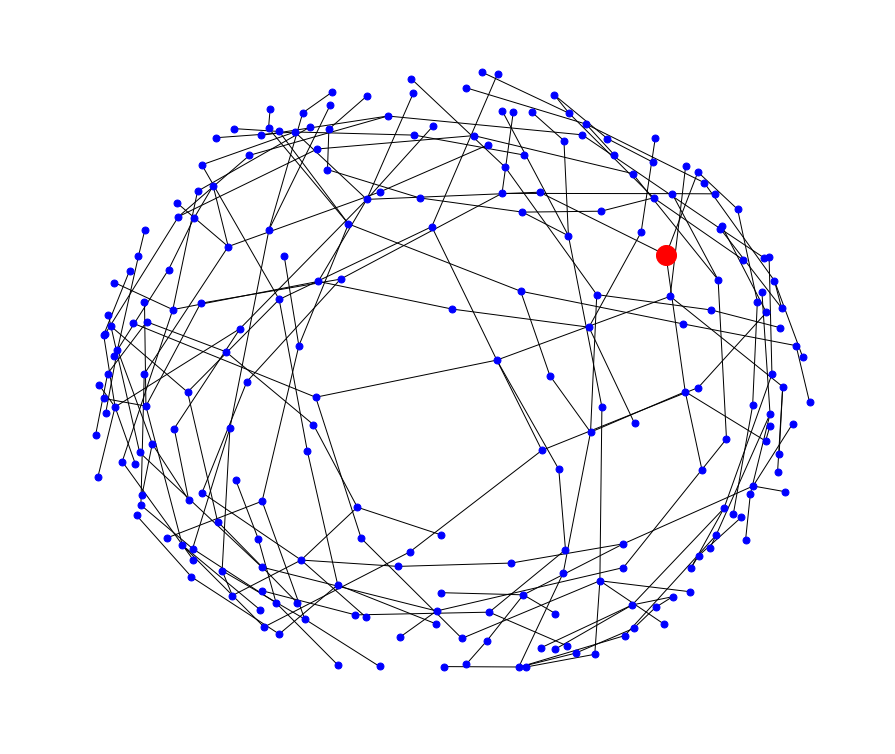

In [30]:
warnings.filterwarnings("ignore")
print('Number of nodes: ', nx.number_of_nodes(cgw_e))
plt.figure(figsize=(12,10), dpi=72, frameon=False)
pos=nx.spring_layout(cgw_e, iterations = 25, scale = 5)
nx.draw(cgw_e,pos,node_color='b',node_size=48, with_labels=False)
nx.draw_networkx_nodes(cgw_e,pos,nodelist=[0],node_size=400,node_color='r')
plt.show()

# Erdos-Renyi (LCC) with fixed weights and random positions of the root

Here we present simulations of SI spreading with power-law weights with $\alpha=0.8$ on the Largest Connected Component of Erdos-Renyi graph. We generate the $ER(n,p)$ with $n=1000$ and $p=1/n+\lambda/n^{4/3}$ and $\lambda=0,1,2,3,5$, find the LCC of the graph, sample the weights once (!) and perform 20 runs of simulations with M = 400 repetitions in each simulation (each repetition = choosing the root at random -- second type of averaging). Finally, we plot all obtained average spreading curves.

## Case \lambda=0.

### Generate graph

In [41]:
n=1000
lbd = 0
p=1/n+lbd/np.power(n,4/3)
er_graph = generateLCCErdosRenyi(n,p)
print(nx.info(er_graph))
root = np.random.choice(er_graph.nodes())
print('Number of extra edges:', nx.number_of_edges(er_graph)-nx.number_of_nodes(er_graph)+1)

Name: gnp_random_graph(1000,0.001)
Type: Graph
Number of nodes: 149
Number of edges: 148
Average degree:   1.9866
Number of extra edges: 0


### Get average spreading curves

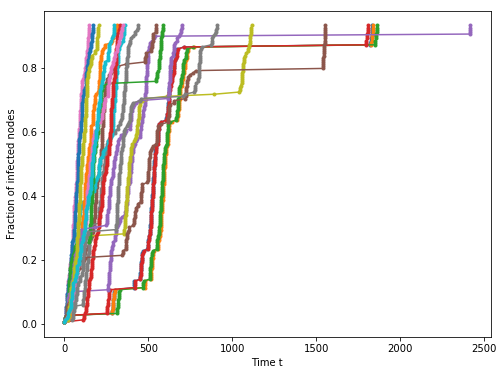

In [94]:
alpha = 0.8
M=400
fig = plt.figure(figsize=(8,6))
num_repetitions=20

pool = mp.Pool(processes=4)
seeds = [np.random.randint(0,4294967295) for i in range(0,num_repetitions)]
parallel_results = [pool.apply_async(getAverageSpreadingCurveFixedWeights, args=(M,s,er_graph,alpha,)) for s in seeds]
for p in parallel_results:
    result = p.get()
    averageT = result[0]
    fractionT = result[1]
    plt.plot(averageT[:-10], fractionT[:-10], marker='.')
    
plt.xlabel('Time t')
plt.ylabel('Fraction of infected nodes')
plt.show()

## Case \lambda=1.

### Generate graph

In [101]:
n=1000
lbd = 1
p=1/n+lbd/np.power(n,4/3)
er_graph = generateLCCErdosRenyi(n,p)
print(nx.info(er_graph))
root = np.random.choice(er_graph.nodes())
print('Number of extra edges:', nx.number_of_edges(er_graph)-nx.number_of_nodes(er_graph)+1)

Name: gnp_random_graph(1000,0.0011)
Type: Graph
Number of nodes: 188
Number of edges: 189
Average degree:   2.0106
Number of extra edges: 2


### Get average spreading curves

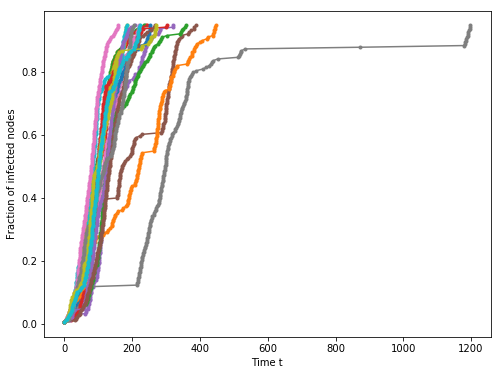

In [102]:
alpha = 0.8
M=400
fig = plt.figure(figsize=(8,6))
num_repetitions=20

pool = mp.Pool(processes=4)
seeds = [np.random.randint(0,4294967295) for i in range(0,num_repetitions)]
parallel_results = [pool.apply_async(getAverageSpreadingCurveFixedWeights, args=(M,s,er_graph,alpha,)) for s in seeds]
for p in parallel_results:
    result = p.get()
    averageT = result[0]
    fractionT = result[1]
    plt.plot(averageT[:-10], fractionT[:-10], marker='.')
    
plt.xlabel('Time t')
plt.ylabel('Fraction of infected nodes')
plt.show()

## Case \lambda=3.

### Generate graph

In [123]:
n=1000
lbd = 3
p=1/n+lbd/np.power(n,4/3)
er_graph = generateLCCErdosRenyi(n,p)
print(nx.info(er_graph))
root = np.random.choice(er_graph.nodes())
print('Number of extra edges:', nx.number_of_edges(er_graph)-nx.number_of_nodes(er_graph)+1)

Name: gnp_random_graph(1000,0.0013)
Type: Graph
Number of nodes: 397
Number of edges: 402
Average degree:   2.0252
Number of extra edges: 6


### Get average spreading curves

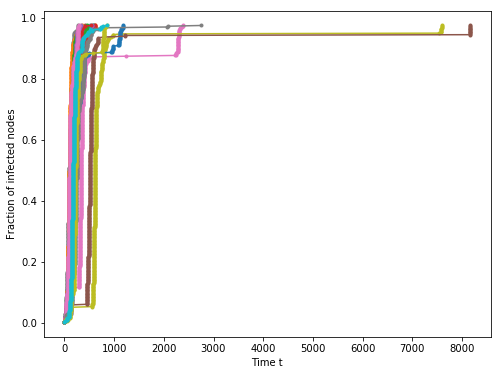

In [124]:
alpha = 0.8
M=400
fig = plt.figure(figsize=(8,6))
num_repetitions=20

pool = mp.Pool(processes=4)
seeds = [np.random.randint(0,4294967295) for i in range(0,num_repetitions)]
parallel_results = [pool.apply_async(getAverageSpreadingCurveFixedWeights, args=(M,s,er_graph,alpha,)) for s in seeds]
for p in parallel_results:
    result = p.get()
    averageT = result[0]
    fractionT = result[1]
    plt.plot(averageT[:-10], fractionT[:-10], marker='.')
    
plt.xlabel('Time t')
plt.ylabel('Fraction of infected nodes')
plt.show()

## Case \lambda=5.

### Generate graph

In [126]:
n=1000
lbd = 5
p=1/n+lbd/np.power(n,4/3)
er_graph = generateLCCErdosRenyi(n,p)
print(nx.info(er_graph))
root = np.random.choice(er_graph.nodes())
print('Number of extra edges:', nx.number_of_edges(er_graph)-nx.number_of_nodes(er_graph)+1)

Name: gnp_random_graph(1000,0.0015)
Type: Graph
Number of nodes: 544
Number of edges: 566
Average degree:   2.0809
Number of extra edges: 23


### Get average spreading curves

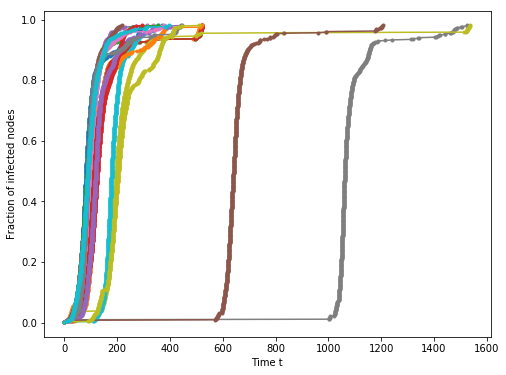

In [131]:
alpha = 0.8
M=400
fig = plt.figure(figsize=(8,6))
num_repetitions=20

pool = mp.Pool(processes=4)
seeds = [np.random.randint(0,4294967295) for i in range(0,num_repetitions)]
parallel_results = [pool.apply_async(getAverageSpreadingCurveFixedWeights, args=(M,s,er_graph,alpha,)) for s in seeds]
for p in parallel_results:
    result = p.get()
    averageT = result[0]
    fractionT = result[1]
    plt.plot(averageT[:-10], fractionT[:-10], marker='.')
    
plt.xlabel('Time t')
plt.ylabel('Fraction of infected nodes')
plt.show()

Conclusion: with the increase of $\lambda$ there are more and more extra edges and size of the component grows. However, these extra edges are enough to smooth out the plateaux, leaving only the those at the bottom and those at the top of the plot.

# Statistics for ER LCC size and extra edge number

Here we check if the distribution of extra edge numbers follows $Poi(O(\lambda))$ distribution and see what is the distribution of sizes of ER LCCs. We test $\lambda=1,3,5$. For each $\lambda$ we do 100 generations of $ER(3000,p)$, and count the statistics. Then we create histograms of our values of interest.

## \lambda = 1

In [140]:
lbd = 1
n=3000
p=1/n+lbd/np.power(n,4/3)
num_repetitions = 100
array_extra_edge_counts = []
array_sizes_lcc = []

def parallel_function(seed, i):
    np.random.seed(seed)
    if i%10==0:
        clear_output()
        print('Run number:', i)
    h = generateLCCErdosRenyi(n,p)
    extra_edge_count = nx.number_of_edges(h) - nx.number_of_nodes(h) + 1
    lcc_nodes = nx.number_of_nodes(h)
    return [extra_edge_count, lcc_nodes]

pool = mp.Pool(processes=4)
seeds = [np.random.randint(0,4294967295) for i in range(0,num_repetitions)]
parallel_results = [pool.apply_async(parallel_function, args=(s,i,)) for (s,i) in zip(seeds, range(0,num_repetitions))]
for p in parallel_results:
    result = p.get()
    array_extra_edge_counts.append(result[0])
    array_sizes_lcc.append(result[1])
if len(parallel_results) == num_repetitions:
    print('DONE!')

Run number: 90
DONE!


Number of nodes in original ER graph: 3000
Lambda: 1
Average extra edge counts: 1.76 1 : theoretical value
Average size of LCC: 341.09 208.008382305 : theoretical value of $n^{2/3}$


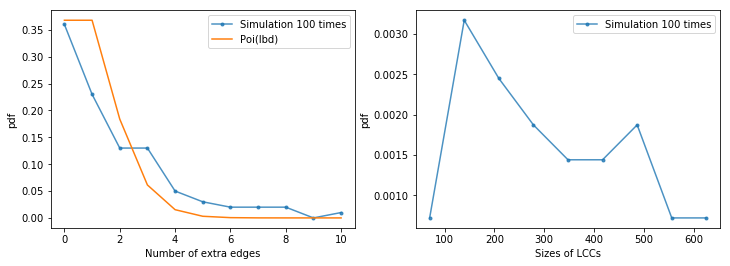

In [145]:
def poisson_pdf(x, lbd):
    f = np.empty(len(x))
    for k in x:
        i = int(k)
        f[i] = (lbd**k/math.factorial(int(k))*np.exp(-lbd))
    return f
print('Number of nodes in original ER graph:', n)
print('Lambda:', lbd)
print('Average extra edge counts:', np.mean(array_extra_edge_counts), lbd, ': theoretical value')
print('Average size of LCC:', np.mean(array_sizes_lcc), np.power(n,2/3), ': theoretical value of $n^{2/3}$')

plt.figure(figsize=(12,4))
plt.subplot(121)
linbins = np.linspace(0,max(array_extra_edge_counts), max(array_extra_edge_counts)+1)
# weights = [1/100000 for i in range(0,len(bunch_hawkes_root))]
# plt.figure(figsize=(8,6))
hist, bins = np.histogram(array_extra_edge_counts, bins=linbins, normed=True)
plot_label = 'Simulation ' + str(len(array_extra_edge_counts)) + ' times'
plt.plot(bins[:-1], hist, marker='.', alpha = 0.8, label=plot_label)
plt.plot(bins[:-1], poisson_pdf(bins[:-1],lbd), label='Poi(lbd)')
plt.xlabel('Number of extra edges')
plt.ylabel('pdf')
plt.legend(loc=1)

plt.subplot(122)
linbins = np.linspace(min(array_sizes_lcc),max(array_sizes_lcc), int(np.sqrt(len(array_sizes_lcc))))
# weights = [1/100000 for i in range(0,len(bunch_hawkes_root))]
hist, bins = np.histogram(array_sizes_lcc, bins=linbins, normed=True)
plot_label = 'Simulation ' + str(len(array_sizes_lcc)) + ' times'
plt.plot(bins[:-1], hist, marker='.', alpha = 0.8, label=plot_label)
plt.legend(loc=1)
plt.xlabel('Sizes of LCCs')
plt.ylabel('pdf')
plt.show()

## \lambda = 3

In [147]:
lbd = 3
n=3000
p=1/n+lbd/np.power(n,4/3)
num_repetitions = 100
array_extra_edge_counts = []
array_sizes_lcc = []

def parallel_function(seed, i):
    np.random.seed(seed)
    if i%10==0:
        clear_output()
        print('Run number:', i)
    h = generateLCCErdosRenyi(n,p)
    extra_edge_count = nx.number_of_edges(h) - nx.number_of_nodes(h) + 1
    lcc_nodes = nx.number_of_nodes(h)
    return [extra_edge_count, lcc_nodes]

pool = mp.Pool(processes=4)
seeds = [np.random.randint(0,4294967295) for i in range(0,num_repetitions)]
parallel_results = [pool.apply_async(parallel_function, args=(s,i,)) for (s,i) in zip(seeds, range(0,num_repetitions))]
for p in parallel_results:
    result = p.get()
    array_extra_edge_counts.append(result[0])
    array_sizes_lcc.append(result[1])
if len(parallel_results) == num_repetitions:
    print('DONE!')

Run number: 90
DONE!


Number of nodes in original ER graph: 3000
Lambda: 3
Average extra edge counts: 13.1 3 : theoretical value
Average size of LCC: 925.2 208.008382305 : theoretical value of $n^{2/3}$


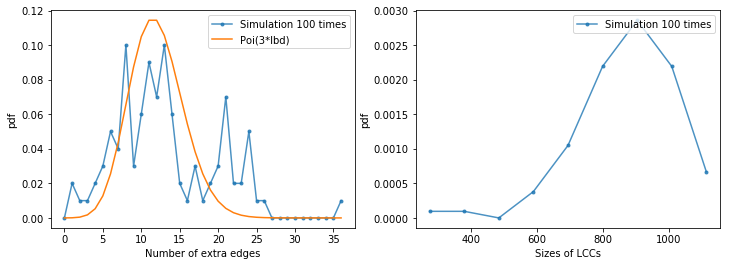

In [151]:
def poisson_pdf(x, lbd):
    f = np.empty(len(x))
    for k in x:
        i = int(k)
        f[i] = (lbd**k/math.factorial(int(k))*np.exp(-lbd))
    return f
print('Number of nodes in original ER graph:', n)
print('Lambda:', lbd)
print('Average extra edge counts:', np.mean(array_extra_edge_counts), lbd, ': theoretical value')
print('Average size of LCC:', np.mean(array_sizes_lcc), np.power(n,2/3), ': theoretical value of $n^{2/3}$')

plt.figure(figsize=(12,4))
plt.subplot(121)
linbins = np.linspace(0,max(array_extra_edge_counts), max(array_extra_edge_counts)+1)
# weights = [1/100000 for i in range(0,len(bunch_hawkes_root))]
# plt.figure(figsize=(8,6))
hist, bins = np.histogram(array_extra_edge_counts, bins=linbins, normed=True)
plot_label = 'Simulation ' + str(len(array_extra_edge_counts)) + ' times'
plt.plot(bins[:-1], hist, marker='.', alpha = 0.8, label=plot_label)
plt.plot(bins[:-1], poisson_pdf(bins[:-1],3*lbd), label='Poi(3*lbd)')
plt.xlabel('Number of extra edges')
plt.ylabel('pdf')
plt.legend(loc=1)

plt.subplot(122)
linbins = np.linspace(min(array_sizes_lcc),max(array_sizes_lcc), int(np.sqrt(len(array_sizes_lcc))))
# weights = [1/100000 for i in range(0,len(bunch_hawkes_root))]
hist, bins = np.histogram(array_sizes_lcc, bins=linbins, normed=True)
plot_label = 'Simulation ' + str(len(array_sizes_lcc)) + ' times'
plt.plot(bins[:-1], hist, marker='.', alpha = 0.8, label=plot_label)
plt.legend(loc=1)
plt.xlabel('Sizes of LCCs')
plt.ylabel('pdf')
plt.show()

## \lambda = 5

In [152]:
lbd = 5
n=3000
p=1/n+lbd/np.power(n,4/3)
num_repetitions = 100
array_extra_edge_counts = []
array_sizes_lcc = []

def parallel_function(seed, i):
    np.random.seed(seed)
    if i%10==0:
        clear_output()
        print('Run number:', i)
    h = generateLCCErdosRenyi(n,p)
    extra_edge_count = nx.number_of_edges(h) - nx.number_of_nodes(h) + 1
    lcc_nodes = nx.number_of_nodes(h)
    return [extra_edge_count, lcc_nodes]

pool = mp.Pool(processes=4)
seeds = [np.random.randint(0,4294967295) for i in range(0,num_repetitions)]
parallel_results = [pool.apply_async(parallel_function, args=(s,i,)) for (s,i) in zip(seeds, range(0,num_repetitions))]
for p in parallel_results:
    result = p.get()
    array_extra_edge_counts.append(result[0])
    array_sizes_lcc.append(result[1])
if len(parallel_results) == num_repetitions:
    print('DONE!')

Run number: 80
Run number: 90
DONE!


Number of nodes in original ER graph: 3000
Lambda: 5
Average extra edge counts: 45.85 5 : theoretical value
Average size of LCC: 1375.08 208.008382305 : theoretical value of $n^{2/3}$


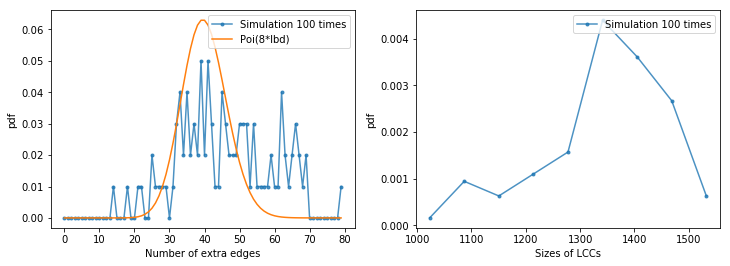

In [154]:
def poisson_pdf(x, lbd):
    f = np.empty(len(x))
    for k in x:
        i = int(k)
        f[i] = (lbd**k/math.factorial(int(k))*np.exp(-lbd))
    return f
print('Number of nodes in original ER graph:', n)
print('Lambda:', lbd)
print('Average extra edge counts:', np.mean(array_extra_edge_counts), lbd, ': theoretical value')
print('Average size of LCC:', np.mean(array_sizes_lcc), np.power(n,2/3), ': theoretical value of $n^{2/3}$')

plt.figure(figsize=(12,4))
plt.subplot(121)
linbins = np.linspace(0,max(array_extra_edge_counts), max(array_extra_edge_counts)+1)
# weights = [1/100000 for i in range(0,len(bunch_hawkes_root))]
# plt.figure(figsize=(8,6))
hist, bins = np.histogram(array_extra_edge_counts, bins=linbins, normed=True)
plot_label = 'Simulation ' + str(len(array_extra_edge_counts)) + ' times'
plt.plot(bins[:-1], hist, marker='.', alpha = 0.8, label=plot_label)
plt.plot(bins[:-1], poisson_pdf(bins[:-1],8*lbd), label='Poi(8*lbd)')
plt.xlabel('Number of extra edges')
plt.ylabel('pdf')
plt.legend(loc=1)

plt.subplot(122)
linbins = np.linspace(min(array_sizes_lcc),max(array_sizes_lcc), int(np.sqrt(len(array_sizes_lcc))))
# weights = [1/100000 for i in range(0,len(bunch_hawkes_root))]
hist, bins = np.histogram(array_sizes_lcc, bins=linbins, normed=True)
plot_label = 'Simulation ' + str(len(array_sizes_lcc)) + ' times'
plt.plot(bins[:-1], hist, marker='.', alpha = 0.8, label=plot_label)
plt.legend(loc=1)
plt.xlabel('Sizes of LCCs')
plt.ylabel('pdf')
plt.show()

Conclusion: there appears to be no common multiplier for $O(\lambda)$ in $Poi(O(\lambda))$..

# CGW with fixed weights and random position of the root

Here we test the same model of spreading as in $ER(n,p)$ for CGW - we first sample the edge weights and then perform M=400 simulations with random positions of the root. The graph on the left is for the generated CGW and on the right for CGW+edge.

### Generate a graph

In [161]:
depth = 20
cgw = generateCGWConditionedDepth(depth)
cgw_e = addExtraEdgeCGW(cgw)
print('Number of nodes: ', nx.number_of_nodes(cgw))
print('Number of edges: ', nx.number_of_edges(cgw))
print('Number of edges + extra edge: ', nx.number_of_edges(cgw_e))

Number of nodes:  174
Number of edges:  173
Number of edges + extra edge:  174


### Plot average spreading curves for CGW with and without extra edge

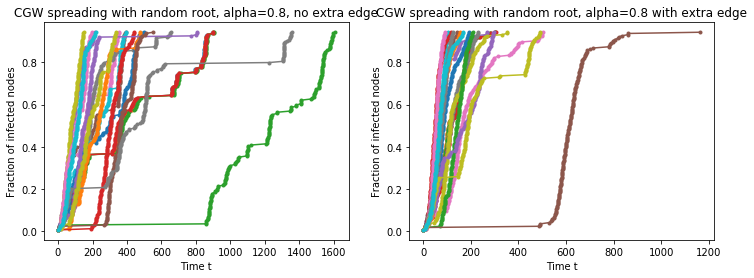

In [171]:
alpha = 0.8
M=400
num_repetitions = 20
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
pool = mp.Pool(processes=4)
seeds = [np.random.randint(0,4294967295) for i in range(0,num_repetitions)]
parallel_results = [pool.apply_async(getAverageSpreadingCurveFixedWeights, args=(M,s,cgw,alpha,)) for s in seeds]
for p in parallel_results:
    result = p.get()
    averageT = result[0]
    fractionT = result[1]
    plt.plot(averageT[:-10], fractionT[:-10], marker='.')

plt.title('CGW spreading with random root, alpha=' + str(alpha) + ', no extra edge')
plt.xlabel('Time t')
plt.ylabel('Fraction of infected nodes')

plt.subplot(122)
pool = mp.Pool(processes=4)
seeds = [np.random.randint(0,4294967295) for i in range(0,num_repetitions)]
parallel_results = [pool.apply_async(getAverageSpreadingCurveFixedWeights, args=(M,s,cgw_e,alpha,)) for s in seeds]
for p in parallel_results:
    result = p.get()
    averageT = result[0]
    fractionT = result[1]
    plt.plot(averageT[:-10], fractionT[:-10], marker='.')

plt.title('CGW spreading with random root, alpha=' + str(alpha) + ' with extra edge')
plt.xlabel('Time t')
plt.ylabel('Fraction of infected nodes')

plt.show()